## Lab Exame - CMC-13
### Equipe:


### 1. Preparação dos dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import geopandas as gpd
from sklearn.neighbors import NearestNeighbors


df_train = pd.read_csv('./apartments_for_rent_train.csv',index_col=0, sep=',')
df_test = pd.read_csv('./apartments_for_rent_test.csv',index_col=0, sep=',')
print(df_train.shape, df_test.shape)

(8001, 21) (1799, 21)


In [2]:
df_train.head()

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,pets_allowed,...,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5668626895,housing/rent/apartment,"Studio apartment 2nd St NE, Uhland Terrace NE,...","This unit is located at second St NE, Uhland T...",NaN,NaN,0.0,USD,No,NaN,...,$790,Monthly,101,NaN,Washington,DC,389.057,-769.861,RentLingo,1.577359e+09
1,5664597177,housing/rent/apartment,Studio apartment 814 Schutte Road,"This unit is located at 814 Schutte Road, Evan...",NaN,NaN,1.0,USD,No,NaN,...,$425,Monthly,106,814 Schutte Rd,Evansville,IN,379.680,-876.621,RentLingo,1.577017e+09
2,5668626833,housing/rent/apartment,"Studio apartment N Scott St, 14th St N, Arling...","This unit is located at N Scott St, 14th St N,...",NaN,1.0,0.0,USD,No,NaN,...,"$1,390",Monthly,107,NaN,Arlington,VA,388.910,-770.816,RentLingo,1.577359e+09
3,5659918074,housing/rent/apartment,Studio apartment 1717 12th Ave,"This unit is located at 1717 12th Ave, Seattle...",NaN,1.0,0.0,USD,No,NaN,...,$925,Monthly,116,1717 12th Avenue,Seattle,WA,476.160,-1.223.275,RentLingo,1.576668e+09
4,5668626759,housing/rent/apartment,"Studio apartment Washington Blvd, N Cleveland ...","This unit is located at Washington Blvd, N Cle...",NaN,NaN,0.0,USD,No,NaN,...,$880,Monthly,125,NaN,Arlington,VA,388.738,-771.055,RentLingo,1.577359e+09


Vamos avaliar a qualidade dos dados e prepará-los para a modelagem.

Vamos começar avaliando a quantidade de valores únicos que temos por coluna

In [3]:
df_train.nunique()

id               8001
category            3
title            7465
body             7963
amenities        2071
bathrooms           5
bedrooms            6
currency            1
fee                 1
pets_allowed        3
price            1515
price_display    1516
price_type          3
square_feet       888
address          5165
cityname         1331
state              50
latitude         2029
longitude        2024
source             12
time             5347
dtype: int64

Vemos que podemos retirar as colunas `currency` e  `fee`, uma vez que elas apresentam apenas um valor único. Todas os dados estão em dólares e os imóveis não apresentam taxa. 

Em paralelo, podemos remover junto a coluna `source` e `time` pois se referem a informações da obtenção dos dados e não serão úteis para nosso modelo.

Vemos também que as colunas `price_display` e `price_type` não são relevantes para o modelo, tendo em vista que já possuímos a variável `price`.

Por fim, podemos remover as colunas `id`, `title` e `body`, já que não trazem informações relevantes para a modelagem, são úicas.

Outro ponto relevante é que 99% dos imóveis estão na categoria de apartamento. Essa variável tem, portanto, baixo poder explicativoa


In [4]:
# count the number of null values in each column
df_train.isnull().sum()

id                  0
category            0
title               0
body                0
amenities        2516
bathrooms          28
bedrooms            5
currency            0
fee                 0
pets_allowed     3400
price               0
price_display       0
price_type          0
square_feet         0
address          2824
cityname           60
state              60
latitude            9
longitude           9
source              0
time                1
dtype: int64

In [5]:
df_train.dtypes

id                 int64
category          object
title             object
body              object
amenities         object
bathrooms        float64
bedrooms         float64
currency          object
fee               object
pets_allowed      object
price              int64
price_display     object
price_type        object
square_feet        int64
address           object
cityname          object
state             object
latitude         float64
longitude         object
source            object
time             float64
dtype: object

Vemos que temos colunas com muitos dados faltantes, esse é o caso de `pets_allowed`, `address`, `city` e `state`. Podemos assim, descartar as colunas `pets_allowed` e `address` para a modelagem. 

Como a informação de localização é bem relevante (heurística) para o modelo, vamos tentar contornar essa falta de dados a partir da biblioteca `geopandas` e da biblioteca `geopy` com os dados de latitude e longitude.

In [6]:
df_train.drop(
    columns=[
        "currency",
        "fee",
        # "source",
        "time",
        "price_display",
        "price_type",
        "id",
        "category",
        "title",
        "body",
        "address",
        # "pets_allowed",
        # "amenities",
        "cityname",
        "state",
    ],
    inplace=True,
)

# tirando as linhas com valores nulos
df_train.dropna(inplace=True)

#### Localização Geográfica

Vamos avaliar as informações de Latitude e Longitude

In [7]:
# Função para corrigir a formatação dos dados
def corrigir_formato(valor):
    if isinstance(valor, str):
        # Detectar se o valor tem dois pontos (milhar incorreto)
        if re.match(r'^-?\d+\.\d+\.\d+$', valor):
            # Remover os pontos de milhar
            valor = valor.replace('.', '', 1)  # Remove apenas o primeiro ponto
        valor = valor.replace(',', '.')  # Garantir que a vírgula seja substituída por ponto
    return float(valor)

# Aplicar a correção na coluna específica (substitua 'longitude' pelo nome da coluna correta)
df_train['longitude'] = df_train['longitude'].dropna().apply(corrigir_formato)
df_train['latitude'] = df_train['latitude'].dropna().apply(corrigir_formato)
df_test['longitude'] = df_test['longitude'].dropna().apply(corrigir_formato)
df_test['latitude'] = df_test['latitude'].dropna().apply(corrigir_formato)

# percebemos que os valores estão multiplicados por 10
df_train[['latitude', 'longitude']] = df_train[['latitude', 'longitude']]/10
df_test[['latitude', 'longitude']] = df_test[['latitude', 'longitude']]/10

Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'FCLASS_TR', 'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT',
       'FCLASS_NL', 'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'geometry'],
      dtype='object', length=169)


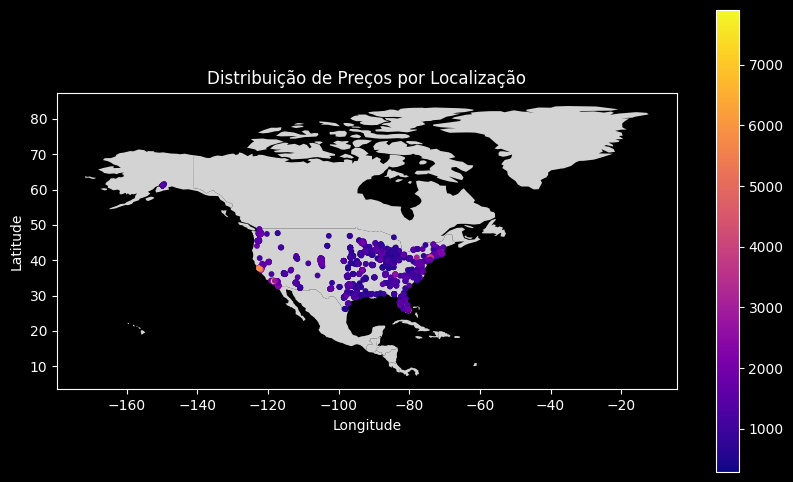

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Criar uma GeoDataFrame
gdf = gpd.GeoDataFrame(df_train, geometry=gpd.points_from_xy(df_train.longitude, df_train.latitude))

# Substitua pelo caminho do seu arquivo baixado
file_path = "./ne_110m_admin_0_countries.zip"

# Carregar o conjunto de dados de países
world = gpd.read_file(file_path)

# Verifique as colunas disponíveis
print(world.columns)

# Ajuste este filtro com base nas colunas disponíveis
# Por exemplo, se a coluna for 'region_un' em vez de 'continent'
north_america = world[world['CONTINENT'] == 'North America']

# Criar a figura e o eixo
fig, ax = plt.subplots(figsize=(10, 6))

# Plotar o mapa da América do Norte
north_america.plot(ax=ax, color='lightgrey')

# Plotar os pontos com a coloração baseada no preço
gdf.plot(ax=ax, column='price', cmap='plasma', markersize=10, legend=True)

# Adicionar título e rótulos
plt.title('Distribuição de Preços por Localização')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Exibir o gráfico
plt.show()


Vemos que a localização geográfica é um dado relevante para o modelo, uma vez que a localização do imóvel pode influenciar no preço. Temo uma concentração de valores mais altos na costa oeste dos EUA.

Com a latitude e longitude separadas é possível desconsiderar as variáveis cidade e estado pois as informações de posição geográfica já estarão contempladas. É melhor tratarmos os dados de lat e long para o modelo pois eles representam variáveis numéricas e não categóricas. Comparando com os dados de cidade e estado, temos uma informação muito granular. Todavia, tratar com lat e long pode ser mais complexo, uma vez que a relação entre essas variáveis e o preço pode não ser linear (o que de fato não é). 

Uma alternativa seria criar uma variável que represente a distância do centro da cidade, ou de um ponto de referência, para o imóvel. Isso poderia ser feito a partir de uma biblioteca de geolocalização, como a `geopy`.

Outra alternativa é determinar clusters de localidades, a partir de algoritmos de clusterização, e utilizar esses clusters como variáveis categóricas para o data set de teste.

Vamos tomar essa decisão mais a frente

#### Amenities

Como temos várias opções dentro da coluna `amenities`, vamos segmentar essas informações em colunas separadas para cada amenidade, transformando em uma variável booleana.

In [9]:
# criando colunas para 'AC', 'Parking' e 'Pool'
df_train['Pool'] = df_train['amenities'].str.contains('Pool', case=1, na=0)
df_train['AC'] = df_train['amenities'].str.contains('AC', case=1, na=0)
df_train['Parking'] = df_train['amenities'].str.contains('Parking', case=1, na=0)
df_train['Hot_tub'] = df_train['amenities'].str.contains('Hot Tub',case=1,na=0)
df_train.drop(columns=["amenities"], inplace=True)

# fazendo o mesmo para pets_allowed
df_train['Cats'] = df_train['pets_allowed'].str.contains('Cats',case=1,na=0)
df_train['Dogs'] = df_train['pets_allowed'].str.contains('Dogs',case=1,na=0)
df_train.drop(columns=["pets_allowed"], inplace=True)

Vamos avaliar os pares e correlacionar as variáveis via `pairplot`

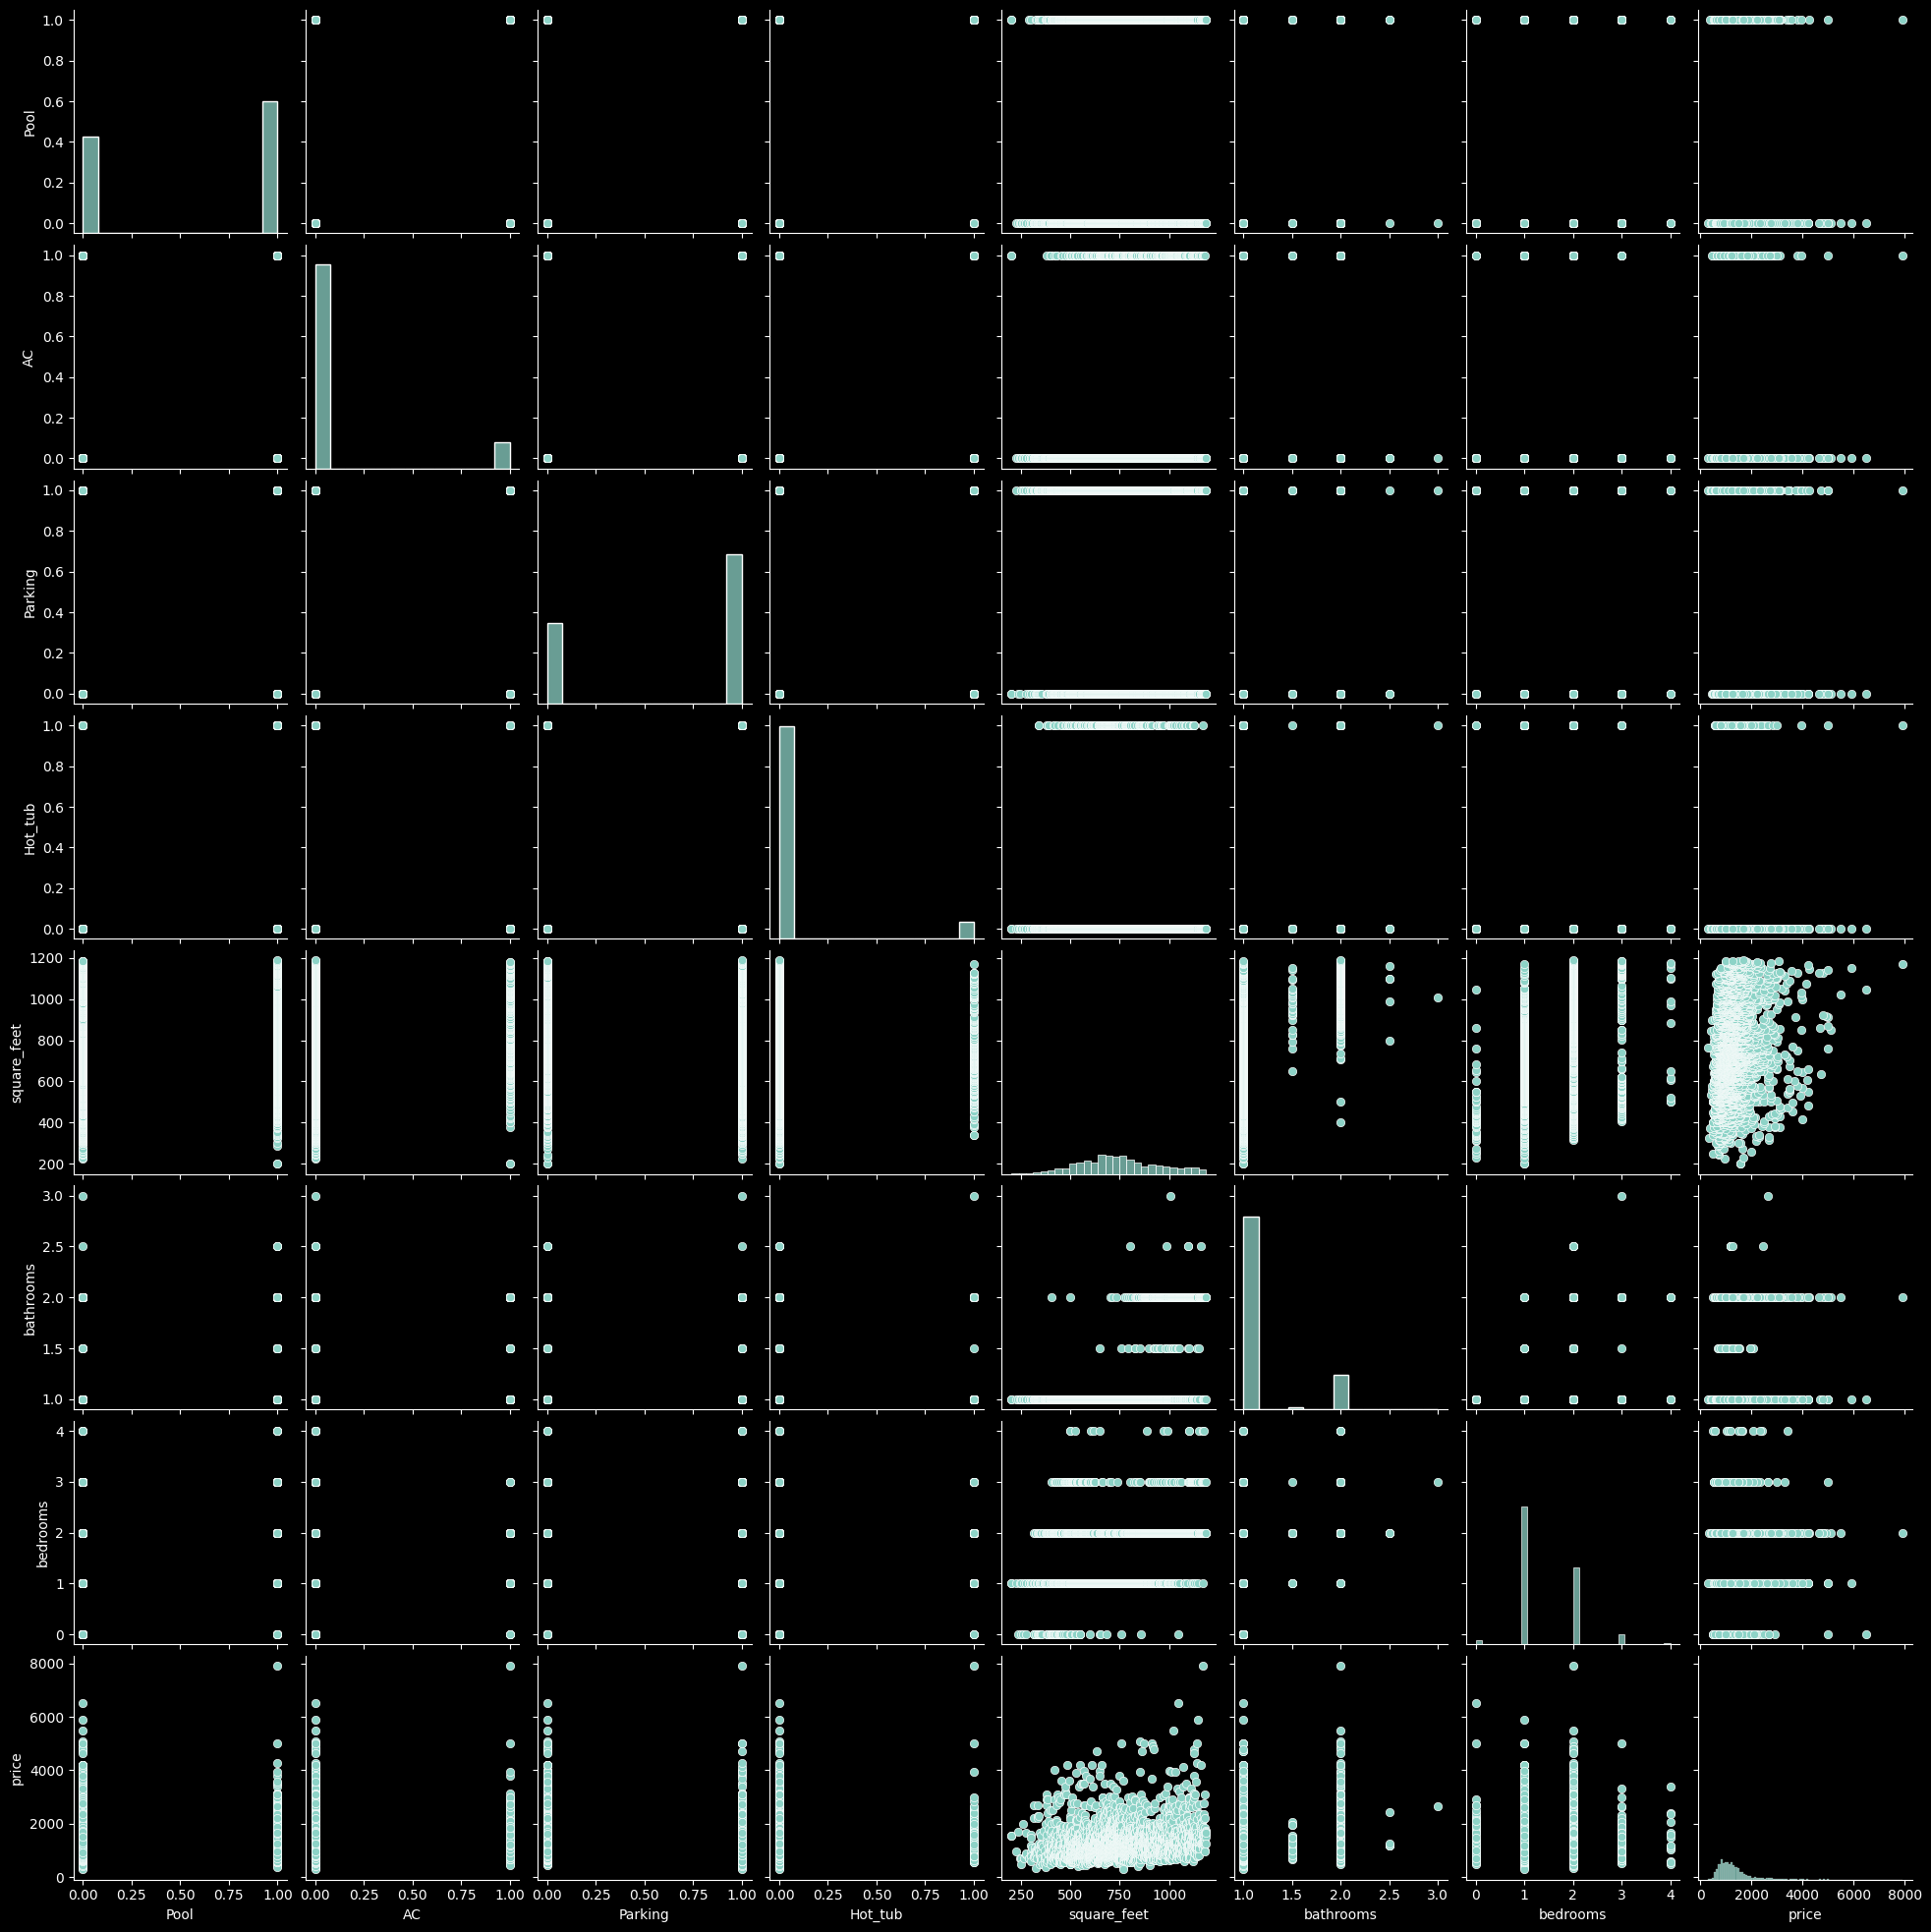

In [10]:
sns.pairplot(df_train[['Pool', 'AC', 'Parking', 'Hot_tub',
             'square_feet', 'bathrooms', 'bedrooms', 'price']])

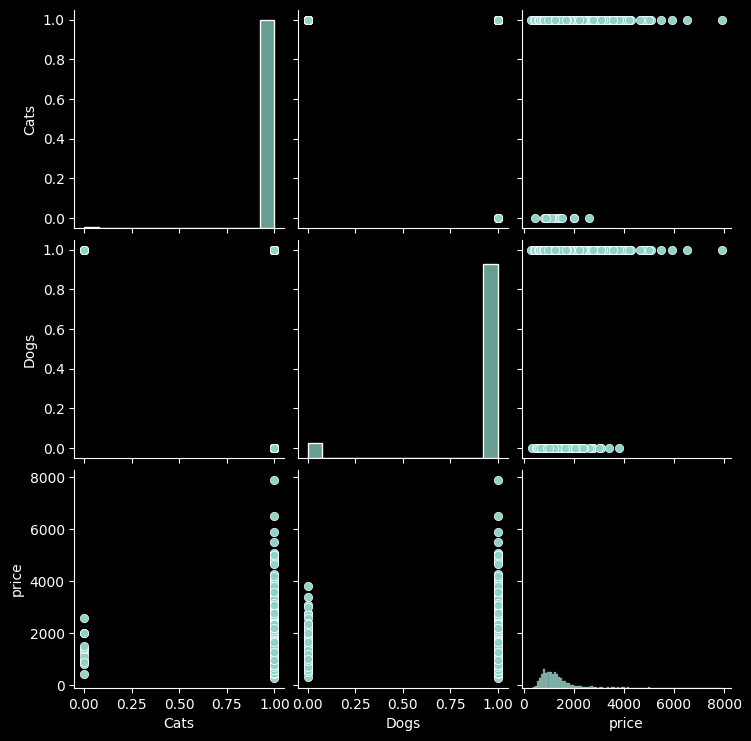

In [11]:
sns.pairplot(df_train[['Cats','Dogs','price']])

Percebe-se que tanto imóveis que aceitam gatos quanto imóveis que aceitam cachorros tendem a ter preços maiores.

In [12]:
df_train['source'].unique()

array(['ListedBuy', 'RentDigs.com', 'RentLingo', 'RENTOCULAR',
       'RealRentals', 'rentbits', 'RENTCaf?1576253157', 'Listanza',
       'tenantcloud'], dtype=object)

In [13]:
df_train.groupby('source',axis=0)['price'].describe()

/var/folders/j3/85v9zb655rq94y5l71nq78nm0000gn/T/ipykernel_80098/3791428311.py:1: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  df_train.groupby('source',axis=0)['price'].describe()


,count,mean,std,min,25%,50%,75%,max
source,,,,,,,,
Listanza,1.0,1950.000000,NaN,1950.0,1950.00,1950.0,1950.0,1950.0
ListedBuy,17.0,1021.352941,429.020242,665.0,750.00,835.0,1092.0,2093.0
RENTCaf?1576253157,1.0,995.000000,NaN,995.0,995.00,995.0,995.0,995.0
RENTOCULAR,4.0,1848.250000,510.332163,1295.0,1559.75,1799.0,2087.5,2500.0
RealRentals,3.0,1738.666667,352.274514,1332.0,1633.00,1934.0,1942.0,1950.0
RentDigs.com,949.0,1394.599579,644.587843,455.0,990.00,1242.0,1625.0,7900.0
RentLingo,2184.0,1238.680861,625.689755,288.0,839.00,1100.0,1425.0,6500.0
rentbits,2.0,1045.000000,70.710678,995.0,1020.00,1045.0,1070.0,1095.0
tenantcloud,1.0,750.000000,NaN,750.0,750.00,750.0,750.0,750.0


Apesar de existirem diferenças nos preços de fontes distintas, são poucas observações de fontes diferentes de 'RentLingo'. Assim, esse atributo será desconsiderado.

In [14]:
df_train.drop(columns=["source"], inplace=True)

# ficamos assim apenas com as colunas
df_train.columns

Index(['bathrooms', 'bedrooms', 'price', 'square_feet', 'latitude',
       'longitude', 'Pool', 'AC', 'Parking', 'Hot_tub', 'Cats', 'Dogs'],
      dtype='object')

##### Preparação para o DF de Teste

In [17]:
df_test = pd.read_csv('./apartments_for_rent_test.csv', index_col=0)
df_test = df_test[['amenities', 'bathrooms', 'bedrooms', 'pets_allowed', 'price',
                   'square_feet', 'latitude', 'longitude']]

# Excluindo valores inexistentes
df_test.dropna(inplace=True)

# criando colunas para 'AC', 'Parking' e 'Pool'
df_test['Pool'] = df_test['amenities'].str.contains('Pool', case=1, na=0)
df_test['AC'] = df_test['amenities'].str.contains('AC', case=1, na=0)
df_test['Parking'] = df_test['amenities'].str.contains('Parking', case=1, na=0)
df_test['Hot_tub'] = df_test['amenities'].str.contains('Hot Tub', case=1, na=0)

# Processando latitude e longitude
df_test['latitude'] = df_test['latitude']/10
df_test['longitude'] = df_test['longitude'].apply(corrigir_formato)/10

# Criando colunas para verificar se aceitam gatos ou cachorros
df_test['Cats'] = df_test['pets_allowed'].str.contains('Cats', case=1, na=0)
df_test['Dogs'] = df_test['pets_allowed'].str.contains('Dogs', case=1, na=0)

# Excluindo colunas desnecessarias
df_test.drop(['amenities', 'pets_allowed'], inplace=True, axis=1)
df_test

,bathrooms,bedrooms,price,square_feet,latitude,longitude,Pool,AC,Parking,Hot_tub,Cats,Dogs
8002,2.0,2.0,1699,1188,34.0072,-84.0034,True,False,False,False,True,True
8003,1.0,2.0,1695,1189,43.0724,-89.4003,False,False,True,False,True,True
8009,2.0,2.0,1800,1190,43.0724,-89.4003,False,False,True,False,True,False
8011,2.0,2.0,1503,1190,37.6202,-77.6128,True,False,True,False,True,True
8012,1.0,1.0,1470,1190,32.0057,-102.1036,False,False,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
9769,3.0,4.0,1750,2397,30.0021,-95.2555,False,False,False,False,True,True
9782,2.0,4.0,1699,2425,32.5942,-96.7624,False,False,False,False,True,True
9783,2.0,4.0,1699,2426,34.1241,-84.0331,False,False,False,False,True,True
9792,2.0,3.0,1549,2446,32.5900,-96.9436,False,False,False,False,True,True
